In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Blood detection model

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess dataset
data_dir =r'/content/drive/MyDrive/Dataset_4 Blood_Detection_Dataset'
img_size = 224
batch_size = 32
aug = True

# Rescaling
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 819 images belonging to 2 classes.
Found 203 images belonging to 2 classes.


{'Blood_Images': 0, 'Non_Blood_Images': 1}
['Blood_Images', 'Non_Blood_Images']


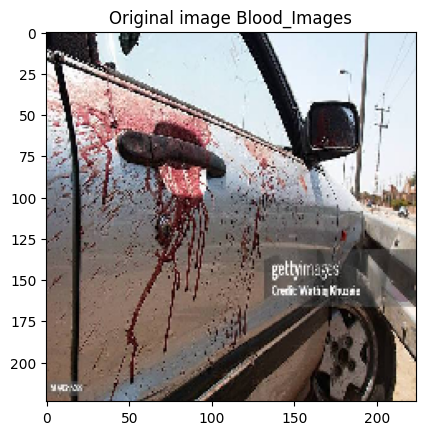

0.0


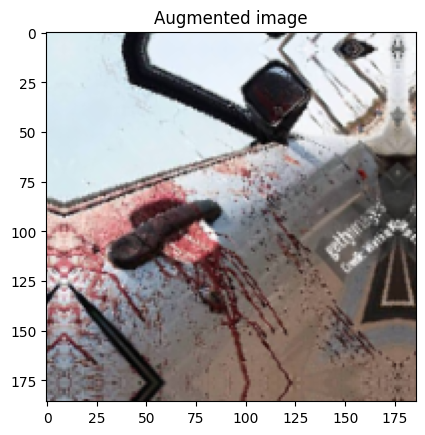

In [5]:
# Visualize

%matplotlib inline

class_dict = train_generator.class_indices
print(class_dict)
classes = list(class_dict.keys())
print(classes)

# Augmented output
augmented_layers = tf.keras.Sequential([
        layers.RandomCrop(int(img_size*5/6),int(img_size*5/6)),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2),
        layers.RandomContrast(0.2)
        ])


for image_batch, labels_batch in train_generator:
  plt.imshow(np.round(image_batch[0]*255.).astype("uint8"))
  plt.title(f"Original image {classes[int(labels_batch[0])]}")
  plt.show()
  #print(image_batch[0])
  print(labels_batch[0])

  augmented_image = augmented_layers(tf.expand_dims(image_batch[0],axis=0))
  plt.imshow(tf.squeeze(augmented_image))
  plt.title("Augmented image")
  plt.show()
  break


In [6]:
def create_model(aug=True):
  # Defining augmentations
  augmented_layers = tf.keras.Sequential([
          layers.RandomCrop(int(img_size*5/6),int(img_size*5/6)),
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.2),
          layers.RandomZoom(0.2),
          layers.RandomContrast(0.2)
          ], name = "Augmented_layer")


  # Load pretrained model and add custom layers
  input = layers.Input(shape=(img_size, img_size, 3))
  if aug ==True:
    x = augmented_layers(input)
  else:
    x = input

  base_model = VGG16(weights='imagenet', include_top=False)
 #base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)  # Try resnet 50
  # Freeze the base model layers
  base_model.trainable = False
  x = base_model(x)
  x = GlobalAveragePooling2D()(x)
  x = Dense(512, activation='relu',kernel_regularizer='l1')(x)#1024
  x = layers.BatchNormalization()(x) #################
  x = layers.Dropout(0.5)(x)
  x = layers.ReLU()(x)
  predictions = Dense(1, activation='sigmoid')(x)

  model = Model(inputs=input, outputs=predictions)

  """
  # Freeze the base model layers
  for layer in base_model.layers:
      layer.trainable = False """

  model.summary()

  return model


model = create_model(aug)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Augmented_layer (Sequential)         │ (None, 186, 186, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 5, 5, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,979,905 (57.14 MB)

 Trainable params: 264,193 (1.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [25]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

first_epochs = 50

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

# Model Checkpoint
model_checkpoint = ModelCheckpoint(r'/content/drive/MyDrive/Codes/Blood_Detection/Model/best_blood_detection_model_with_VGG16.weights.h5', save_best_only=True,
                                   save_weights_only=True, monitor='val_loss', verbose=1)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_1=model.fit(train_generator, validation_data=validation_generator,
                    callbacks=[reduce_lr, early_stopping, model_checkpoint], epochs=first_epochs,shuffle=True)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7499 - loss: 1.2157
Epoch 1: val_loss improved from inf to 1.29116, saving model to /content/drive/MyDrive/Codes/Blood_Detection/Model/best_blood_detection_model_with_VGG16.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 549ms/step - accuracy: 0.7491 - loss: 1.2152 - val_accuracy: 0.6010 - val_loss: 1.2912 - learning_rate: 1.0000e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.7213 - loss: 1.1406
Epoch 2: val_loss improved from 1.29116 to 1.27249, saving model to /content/drive/MyDrive/Codes/Blood_Detection/Model/best_blood_detection_model_with_VGG16.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 15s 482ms/step - accuracy: 0.7215 - loss: 1.1398 - val_accuracy: 0.5419 - val_loss: 1.2725 - learning_rate: 1.0000e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.7103 - loss: 1.1186
Epoch 3: val_loss improved from 1.27249 to 1.21358, saving model to /content/drive/MyDrive/Codes/Blood_Detection/Model

In [26]:
# Saving the final model weights
model.save_weights(r'/content/drive/MyDrive/Codes/Blood_Detection/Model/last_blood_detection_model_weights_VGG16.weights.h5')

# Loading the weights
"""
# Recreate the model architecture
model = create_model()  # Replace with your model creation code

# Load the saved weights
model.load_weights(r'Model\last_blood_detection_model_weights.weights.h5')
"""


"\n# Recreate the model architecture\nmodel = create_model()  # Replace with your model creation code\n\n# Load the saved weights\nmodel.load_weights(r'Model\\last_blood_detection_model_weights.weights.h5')\n"

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 579ms/step - accuracy: 0.6587 - loss: 1.1746


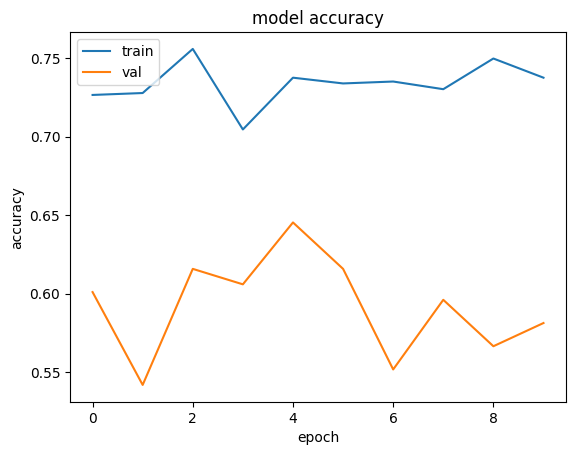

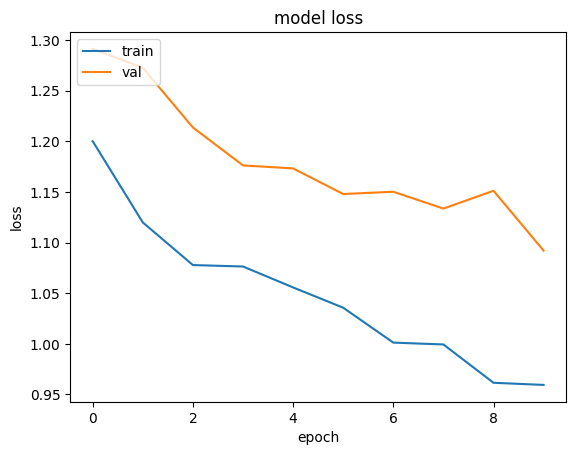

In [27]:
model.evaluate(validation_generator)

# Plot

%matplotlib inline

def plot_history(history):
  keys = list(history.history.keys())
  for i in range(len(keys)//2):
    plt.plot(history.history[keys[i]])
    plt.plot(history.history[keys[i+len(keys)//2]])
    plt.title(f'model {keys[i]}')
    plt.ylabel(keys[i])
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(history_1)

### Finetuning

In [28]:
## Loading the weights

# Recreate the model architecture
model_2 = create_model()  # Replace with your model creation code

# Load the saved weights
model_2.load_weights(r'/content/drive/MyDrive/Codes/Blood_Detection/Model/best_blood_detection_model_with_VGG16.weights.h5')#'Model\last_blood_detection_model_weights.weights.h5')


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Augmented_layer (Sequential)         │ (None, 186, 186, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 5, 5, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_5           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,979,905 (57.14 MB)

 Trainable params: 264,193 (1.01 MB)

 Non-trainable params: 14,715,712 (56.14 MB)

In [29]:
for model_2_layer in model_2.layers:
  print(model_2_layer.name, model_2_layer.trainable)

print("\n VGG16 layers \n")
for i,vgg_layer in enumerate(model_2.layers[2].layers):
  print(i, vgg_layer.name, vgg_layer.trainable)

input_layer_16 True
Augmented_layer True
vgg16 False
global_average_pooling2d_5 True
dense_10 True
batch_normalization_5 True
dropout_5 True
re_lu_5 True
dense_11 True

 VGG16 layers 

0 input_layer_18 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [30]:
for i,vgg_layer in enumerate(model_2.layers[2].layers):
  if i<15:
    vgg_layer.trainable = False
  else:
    vgg_layer.trainable = True
  print(i, vgg_layer.name, vgg_layer.trainable)


0 input_layer_18 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [31]:
second_epochs = 50

# Learning Rate Scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6, verbose=1)

# Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)

# Model Checkpoint
model_checkpoint = ModelCheckpoint(r'/content/drive/MyDrive/Codes/Blood_Detection/Model/fine_tuned_best_blood_detection_model_with_VGG16.weights.h5', save_best_only=True,
                                   save_weights_only=True, monitor='val_loss', verbose=1)

# Compile the model
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history_2=model_2.fit(train_generator, validation_data=validation_generator,
                    callbacks=[reduce_lr, early_stopping, model_checkpoint], epochs=second_epochs,shuffle=True)

Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6965 - loss: 1.0387
Epoch 1: val_loss improved from inf to 1.29323, saving model to /content/drive/MyDrive/Codes/Blood_Detection/Model/fine_tuned_best_blood_detection_model_with_VGG16.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 560ms/step - accuracy: 0.6968 - loss: 1.0382 - val_accuracy: 0.5714 - val_loss: 1.2932 - learning_rate: 1.0000e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.7549 - loss: 0.9044
Epoch 2: val_loss improved from 1.29323 to 1.12484, saving model to /content/drive/MyDrive/Codes/Blood_Detection/Model/fine_tuned_best_blood_detection_model_with_VGG16.weights.h5
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 516ms/step - accuracy: 0.7554 - loss: 0.9033 - val_accuracy: 0.6404 - val_loss: 1.1248 - learning_rate: 1.0000e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8003 - loss: 0.8256
Epoch 3: val_loss did not improve from 1.12484
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 479ms/step - accur

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 516ms/step - accuracy: 0.6827 - loss: 1.0633


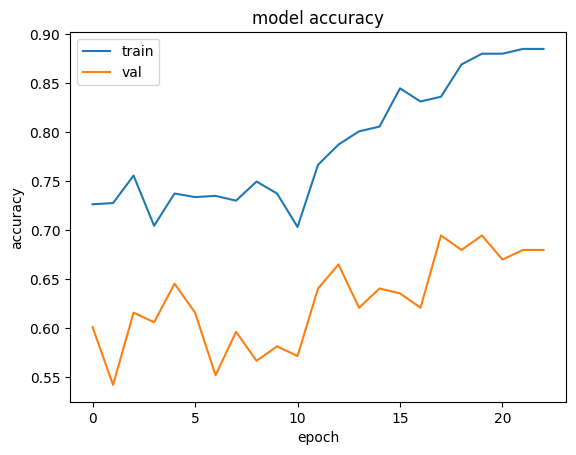

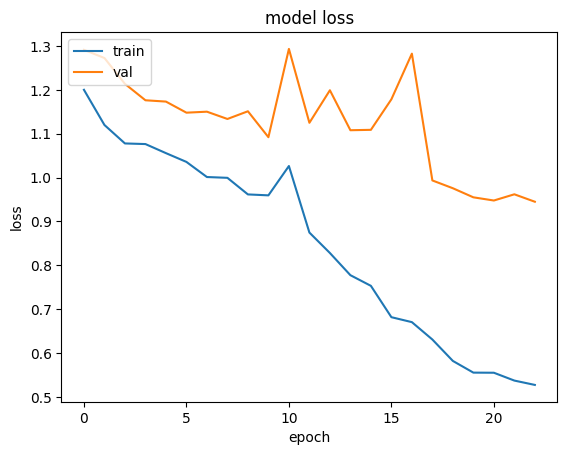

In [32]:
model_2.evaluate(validation_generator)

# Plot

%matplotlib inline

def plot_history(histor_1,history_2):
  keys = list(history_1.history.keys())
  for i in range(len(keys)//2):
    plt.plot(history_1.history[keys[i]]+history_2.history[keys[i]])
    plt.plot(history_1.history[keys[i+len(keys)//2]]+history_2.history[keys[i+len(keys)//2]])
    plt.title(f'model {keys[i]}')
    plt.ylabel(keys[i])
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(history_1,history_2)

### ROC

6/6 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step


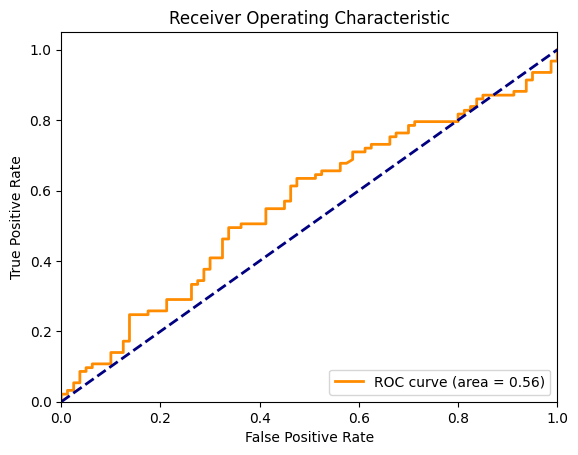

Optimal threshold:  0.5434555


In [ ]:
from sklearn.metrics import roc_curve, auc

# Load the saved model
saved_model = keras.models.load_model(r'Model\blood_detection_model.h5')

# Generate predictions on the validation set
validation_generator.reset()  # Ensure the generator is at the start
predictions = saved_model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_probabilities = predictions.ravel()

# Get true labels
true_labels = validation_generator.classes

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_probabilities)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Find the optimal threshold
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

print('Optimal threshold: ', optimal_threshold)

# Function to classify based on the optimal threshold
def classify(probabilities, threshold):
    return (probabilities >= threshold).astype(int)

# Classify the validation set based on the optimal threshold
predicted_classes = classify(predicted_probabilities, optimal_threshold)

### Blood percentage calculation

In [ ]:
import cv2
import numpy as np
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('Model/blood_detection_model.h5')

# Define blood color range in HSV
lower_blood_hsv = np.array([0, 50, 50])
upper_blood_hsv = np.array([10, 255, 255])

def count_blood_pixels(frame):
    # Convert the frame to HSV color space
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # Create a mask with the blood color range
    blood_mask = cv2.inRange(hsv_frame, lower_blood_hsv, upper_blood_hsv)
    # Count the number of blood pixels
    blood_pixel_count = np.sum(blood_mask > 0.5)#0
    return blood_pixel_count

def classify_video_frames_and_calculate_blood_percentage(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    total_blood_pixels = 0
    blood_frames = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess the frame
        frame_resized = cv2.resize(frame, (img_height, img_width))
        frame_array = np.expand_dims(frame_resized / 255.0, axis=0)

        # Predict
        prediction = model.predict(frame_array)
        if prediction > optimal_threshold:#0.5:
            blood_frames += 1
            blood_pixel_count = count_blood_pixels(frame_resized)
            total_blood_pixels += blood_pixel_count

    cap.release()
    cv2.destroyAllWindows()

    # Calculate blood percentage for the video
    avg_blood_pixels_per_frame = total_blood_pixels / frame_count
    blood_percentage = (avg_blood_pixels_per_frame / (img_height * img_width)) * 100
    blood_scene_duration = (blood_frames / frame_count) * 100

    return blood_percentage, blood_scene_duration

video_path = r"D:\Engineering\Projects\Violence detection\Dataset_4 Multiclass dataset\Abuse\698699.mp4"  #"C:\Users\lathw\Downloads\THE EXORCIST_ BELIEVER _ CLIP _The Body and the Blood_ HD.mp4"  #video path
blood_percentage, blood_scene_duration = classify_video_frames_and_calculate_blood_percentage(video_path)
print(f"Blood percentage in the video: {blood_percentage}%")
print(f"Duration of blood scenes in the video: {blood_scene_duration}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [ ]:
print(avg_blood_pixels_per_frame)
print(img_height * img_width)

NameError: name 'avg_blood_pixels_per_frame' is not defined

### K-mean clustering for dividing into severity classes

In [ ]:
import os

blood_images_dir = r"D:\Engineering\Projects\Violence detection\Dataset_4 Blood_Detection_Dataset\Blood_Images"

def check_path(path):
    if os.path.exists(path):
        #print("The path exists.")
        return 1
    else:
        print("The path does not exist.")
        return 0

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Extract features from images with blood
blood_images_dir = r"D:\Engineering\Projects\Violence detection\Dataset_4 Blood_Detection_Dataset\Blood_Images"

# Assuming you have a function to load and preprocess images
def load_and_preprocess_images(image_dir):
    images = []
    for img_path in os.listdir(image_dir):
        img_path =  os.path.join(image_dir, img_path)
        if check_path(img_path) ==0:
            print(img_path)
        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        images.append(img_array)
    return np.array(images)

blood_images = load_and_preprocess_images(blood_images_dir)

# Extract features using the pretrained model
features_model = Model(inputs=base_model.input, outputs=base_model.output)
features = features_model.predict(blood_images)

# Reshape features to 2D array
features_reshaped = features.reshape(features.shape[0], -1)

# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_reshaped)

# Now you have the cluster labels for each image
print(clusters)

13/13 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step


c:\Users\lathw\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[2 0 0 2 2 0 2 2 2 2 0 2 0 0 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 0 2 2 2
 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 2 0 2 2 2 2 2 0 2 2 2 2
 0 0 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0 2 2 2 0 2 2 1 2 0 2 2 2
 2 2 2 2 2 2 2 2 0 0 2 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 0 2
 2 2 2 2 2 0 0 2 2 2 2 2 2 0 0 0 2 2 2 2 2 2 2 2 0 0 0 0 2 2 2 0 0 2 0 2 0
 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 0 2 2 2 0 0 2 2 2 2 2 0 0 2 2 2 2
 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 0
 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 0 2 2 2 2 2 2 2 2 0 2 2 0 0 2 2 2 2 2 2
 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 0 2 0 2 0 0 2 0 0 2
 0 0 2 0 0 2 2 0 0 0 0 2 2 0 2 2 2 2 1 2 2 2 2 2 2 2 0 2 2 2 0 2 0 2 2 2 1
 1 2 2 2 2 2 0 2 2 0 2 0 2 2 2 2 2 0 2 2 0 2 2 2 2 2 0 0 2 0 2 2 2]
